In [12]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from scipy import signal
from scipy import stats
from matplotlib.dates import date2num
from matplotlib.collections import LineCollection
plt.rcParams['pdf.fonttype'] = 42

In [2]:
minimum_cdk_peak = {"HS360": 1.7, "HS007": 1.7}      # ピークと検出されるために最低限必要なratio値
cmap = sns.color_palette()
cmap_hm = "plasma"

ls = ["-", ":"]
lc = ["blue", "orange"]
sl = ["short", "long"]

data_tot = pd.read_csv("./dir_HS360\_results_individual.csv")
data_length = pd.read_csv("./_lengths_SL.csv")

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


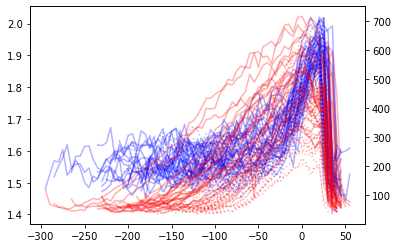

In [3]:
data_plot_timecourse = pd.DataFrame({})
data_plot_smt = pd.DataFrame({})
data_plot_max = pd.DataFrame({})

bins = 16
data_lineplot = pd.DataFrame({})
el_t_bin = np.linspace(0, 1, bins)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

cells = sorted(data_tot["CellID"].unique().tolist())  # originの細胞を重複なく抜き出す
print(cells)
for cell in cells:
    length_at_birth = data_length.loc[(data_length["Cell"] == cell) & (data_length["BD"] == "birth")]["Length"].values.tolist()[0]
    length_at_div = data_length.loc[(data_length["Cell"] == cell) & (data_length["BD"] == "division")]["Length"].values.tolist()[0]
    length_grow = length_at_div - length_at_birth

    df_RFP = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C0"]
    df_FRET = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C1"]
    df_CFP = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C2"]
    SL = int((cell + 1) % 2)
    sl_class = [sl[SL] for k in range(len(df_CFP))]
    el_t = [k*5 for k in range(len(df_CFP))]
    RFP = [cmp for cmp in df_RFP]
    ratio = [cmp for cmp in df_FRET / df_CFP]

    ratio_smt = signal.savgol_filter(ratio, 21, 3)
    RFP_smt = signal.savgol_filter(RFP, 21, 3)

    max_r = max(ratio_smt[:-1])
    min_r = min(ratio_smt[:-1])
    ratio_norm = [(cmp - min_r)/(max_r - min_r) for cmp in ratio_smt][:-1]

    maxid = np.argmax(RFP_smt)
    maxRFP_smt = RFP_smt[maxid]
    maxRatio_smt = ratio[maxid]
    ratio_smt = ratio_smt[:maxid+1]
    RFP_smt = RFP_smt[:maxid+1]

    ratio_dif = [ratio_smt[i+1] - ratio_smt[i] for i in range(len(ratio_smt) - 1)]
    ratio_smt_plt = [cmp for cmp in ratio_smt][:-1]
    RFP_smt_plt = [cmp for cmp in RFP_smt][:-1]
    RFP_bin = [50 * int(cmp/50) for cmp in RFP_smt][:-1]
    time_smt = [-5*len(ratio_dif) + 5*i for i in range(len(ratio_dif))]
    sl_class_smt = [sl[SL] for k in range(len(ratio_dif))]
    cell_smt = [cell for k in range(len(ratio_dif))]

    temp = pd.DataFrame([cell_smt, time_smt, ratio_smt_plt, ratio_norm, ratio_dif, RFP_smt_plt, RFP_bin, sl_class],
                        index=["cell", "time", "CDKEV-raw", "CDKEV-norm", "CDKEV-dif", "cdc13", "cdc13-bin", "SL"])
    data_plot_smt = pd.concat([data_plot_smt, temp.T], ignore_index=True)

    el_t_align = [(k - maxid)*5 for k in range(len(df_CFP))]

    temp = pd.DataFrame([el_t, el_t_align, ratio, RFP, sl_class], index=["time", "aligned-time", "CDKEV-raw", "cdc13", "SL"])
    data_plot_timecourse = pd.concat([data_plot_timecourse, temp.T], ignore_index=True)
    ax1.plot(el_t_align, ratio, color="blue", linestyle=ls[SL], alpha=0.3)
    ax2.plot(el_t_align, RFP, color="red", linestyle=ls[SL], alpha=0.3)

    temp = pd.DataFrame([[cell], [maxRatio_smt], [maxRFP_smt], [5*len(RFP)], [sl[SL]], [SL], [length_at_birth], [length_at_div], [length_grow]],
                        index=["cell", "CDKEV-raw", "cdc13", "duration", "SL", "SL-num", "birth", "division", "grow"])
    data_plot_max = pd.concat([data_plot_max, temp.T], ignore_index=True)

    cycle_length = len(RFP)
    window = int(cycle_length / bins)
    residual = cycle_length % bins
    blocks = [window for i in range(bins)]
    for i in range(residual):
        blocks[i] = blocks[i] + 1
    pos = []
    counter = 0
    for cmp in blocks:
        pos.extend([counter for j in range(cmp)])
        counter += 1

    binned_timecourse_ratio = [[] for j in range(bins)]
    binned_timecourse_RFP = [[] for j in range(bins)]
    for i in range(cycle_length):
        binned_timecourse_ratio[pos[i]].append(ratio[i])
        binned_timecourse_RFP[pos[i]].append(RFP[i])

    binned_timecourse_ratio2 = [np.mean(cmp) for cmp in binned_timecourse_ratio]
    binned_timecourse_RFP2 = [np.mean(cmp) for cmp in binned_timecourse_RFP]
    temp = pd.DataFrame([[k for k in el_t_bin], binned_timecourse_ratio2, binned_timecourse_RFP2, [cell for j in range(len(el_t))],
                         [sl[SL] for j in range(len(el_t))]],
                        index=["time", "CDKEV-raw", "RFP", "id", "SL"])
    data_lineplot = pd.concat([data_lineplot, temp.T], ignore_index=True)

fig.savefig("./___lineplot_all_aligned.png", transparent=False)

data_plot_smt.to_csv("./_data_plt_smt.csv")

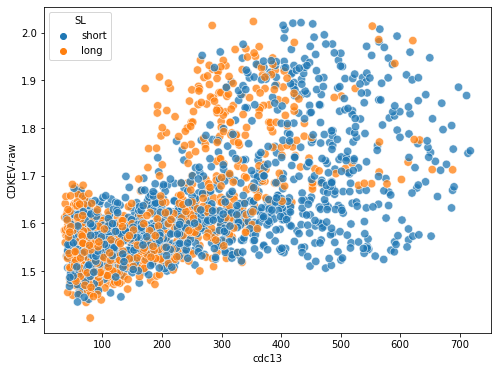

In [6]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="cdc13", y="CDKEV-raw", data=data_plot_timecourse, hue="SL", alpha=0.75, s=70)
fig.savefig("./___scatter_all.png")
fig.savefig("./___scatter_all.pdf")


In [13]:

stats.ttest_rel(data_plot_max.loc[data_plot_max["SL"]=="short"]["cdc13"], data_plot_max.loc[data_plot_max["SL"]=="long"]["cdc13"])

Ttest_relResult(statistic=8.226240168709905, pvalue=1.919672005592893e-08)

In [14]:

stats.ttest_rel(data_plot_max.loc[data_plot_max["SL"]=="short"]["CDKEV-raw"], data_plot_max.loc[data_plot_max["SL"]=="long"]["CDKEV-raw"])

Ttest_relResult(statistic=0.9807138120348339, pvalue=0.33651735585713094)

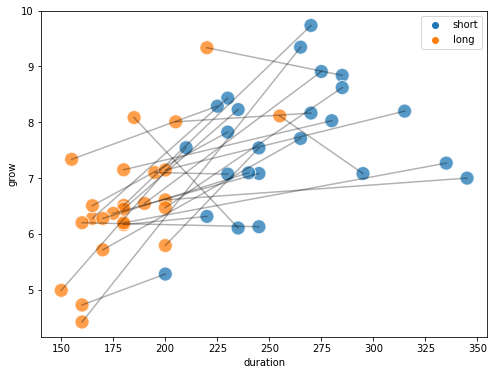

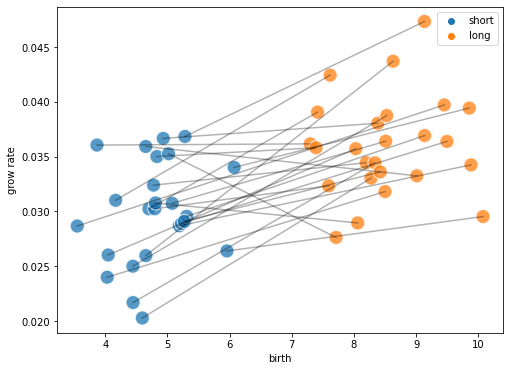

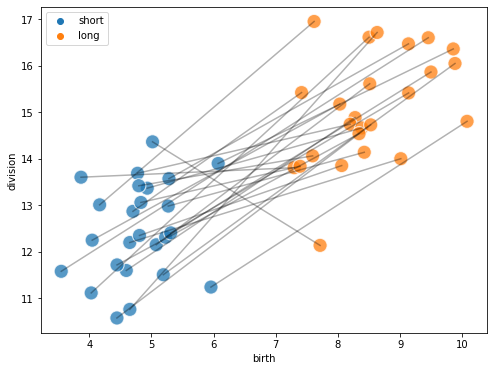

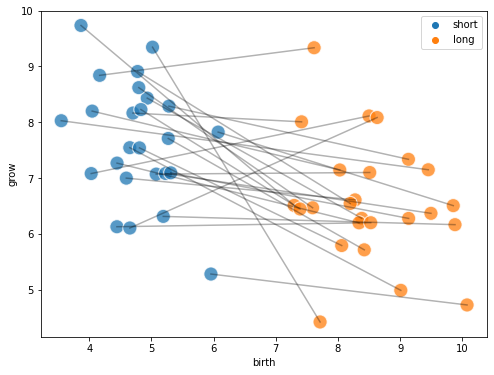

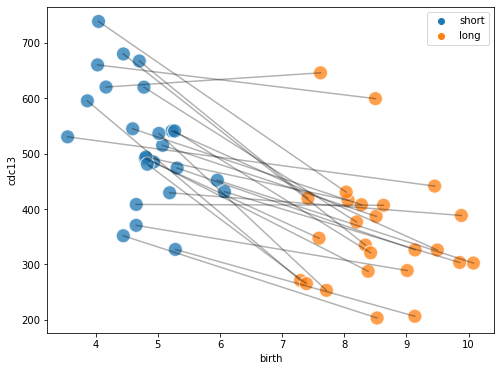

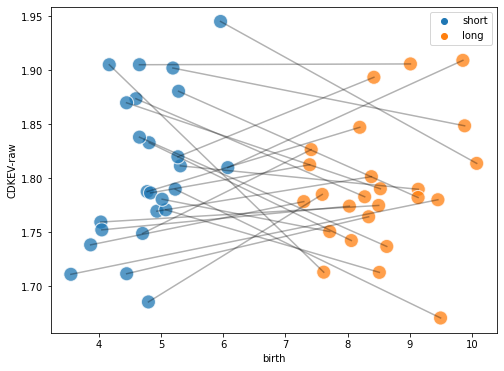

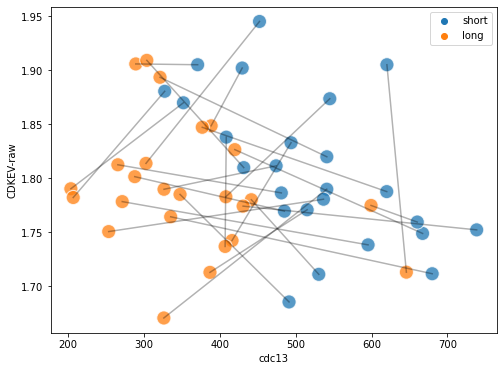

In [9]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="duration", y="grow", data=data_plot_max, hue="SL", alpha=0.75, s=200)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="duration", y="grow", data=data_temp, color="black", alpha=0.3)
fig.savefig("./___scatter_duration-vs-grow-length2.png", transparent=False)
fig.savefig("./___scatter_duration-vs-grow-length2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="birth", y="grow rate", data=data_plot_max, hue="SL", alpha=0.75, s=200)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="birth", y="grow rate", data=data_temp, color="black", alpha=0.3)
fig.savefig("./___scatter_birth-vs-grow-rate2.png", transparent=False)
fig.savefig("./___scatter_birth-vs-grow-rate2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="birth", y="division", data=data_plot_max, hue="SL", alpha=0.75, s=200)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="birth", y="division", data=data_temp, color="black", alpha=0.3)
fig.savefig("./___scatter_birth-vs-division-length2.png", transparent=False)
fig.savefig("./___scatter_birth-vs-division-length2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="birth", y="grow", data=data_plot_max, hue="SL", alpha=0.75, s=200)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="birth", y="grow", data=data_temp, color="black", alpha=0.3)
fig.savefig("./___scatter_birth-vs-grow-length2.png", transparent=False)
fig.savefig("./___scatter_birth-vs-grow-length2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="birth", y="cdc13", data=data_plot_max, hue="SL", alpha=0.75, s=200)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="birth", y="cdc13", data=data_temp, color="black", alpha=0.3)
fig.savefig("./___scatter_birth-vs-cdc13-2.png", transparent=False)
fig.savefig("./___scatter_birth-vs-cdc13-2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="birth", y="CDKEV-raw", data=data_plot_max, hue="SL", alpha=0.75, s=200)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="birth", y="CDKEV-raw", data=data_temp, color="black", alpha=0.3)
fig.savefig("./___scatter_birth-vs-CDKEV2.png", transparent=False)
fig.savefig("./___scatter_birth-vs-CDKEV2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x="cdc13", y="CDKEV-raw", data=data_plot_max, hue="SL", alpha=0.75, s=200)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="cdc13", y="CDKEV-raw", data=data_temp, color="black", alpha=0.3)
fig.savefig("./___scatter_cdc13-vs-CDKEV2.png", transparent=False)
fig.savefig("./___scatter_cdc13-vs-CDKEV2.pdf", transparent=False)



In [23]:
df = data_plot_max.drop("SL", axis=1)
df = df.astype(float)


SL
long     1.791376
short    1.807338
Name: CDKEV-raw, dtype: float64 SL
long     0.058433
short    0.068967
Name: CDKEV-raw, dtype: float64
SL
long     358.364200
short    519.500571
Name: cdc13, dtype: float64 SL
long     104.310114
short    105.985114
Name: cdc13, dtype: float64
SL
long     183.2
short    259.0
Name: duration, dtype: float64 SL
long     23.223551
short    37.165172
Name: duration, dtype: float64


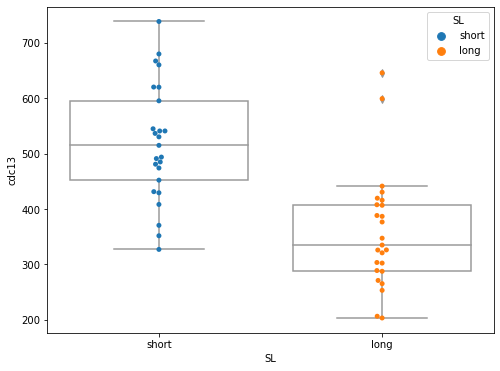

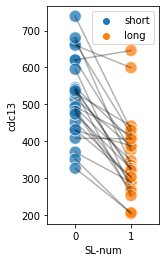

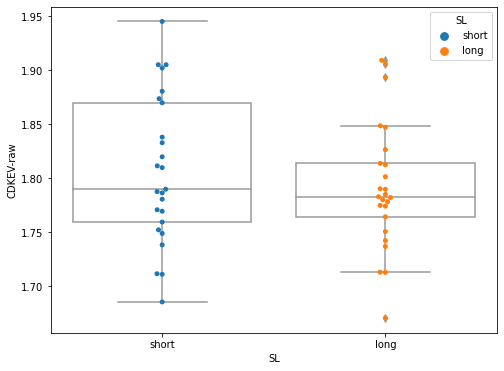

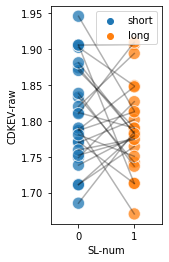

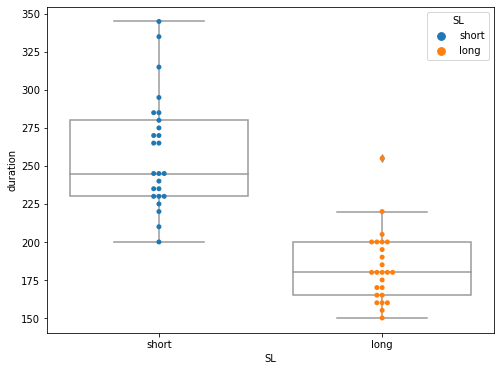

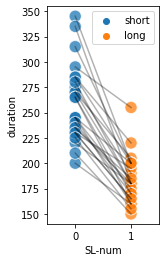

In [11]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="SL", y="cdc13", data=data_plot_max, color="white")
sns.swarmplot(x="SL", y="cdc13", data=data_plot_max, hue="SL")
fig.savefig("./___cdc13-at-div_distribution.png", transparent=False)
fig.savefig("./___cdc13-at-div_distribution.pdf", transparent=False)

fig = plt.figure(figsize=(2, 4))
sns.scatterplot(x="SL-num", y="cdc13", data=data_plot_max, hue="SL", alpha=0.75, s=150)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="SL-num", y="cdc13", data=data_temp, color="black", alpha=0.3)
plt.xlim([-0.5, 1.5])
fig.savefig("./___cdc13-at-div_distribution2.png", transparent=False)
fig.savefig("./___cdc13-at-div_distribution2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="SL", y="CDKEV-raw", data=data_plot_max, color="white")
sns.swarmplot(x="SL", y="CDKEV-raw", data=data_plot_max, hue="SL")
fig.savefig("./___CDK-at-div_distribution.png", transparent=False)
fig.savefig("./___CDK-at-div_distribution.pdf", transparent=False)

fig = plt.figure(figsize=(2, 4))
sns.scatterplot(x="SL-num", y="CDKEV-raw", data=data_plot_max, hue="SL", alpha=0.75, s=150)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="SL-num", y="CDKEV-raw", data=data_temp, color="black", alpha=0.3)
plt.xlim([-0.5, 1.5])
fig.savefig("./___CDK-at-div_distribution2.png", transparent=False)
fig.savefig("./___CDK-at-div_distribution2.pdf", transparent=False)

fig = plt.figure(figsize=(8, 6))
sns.boxplot(x="SL", y="duration", data=data_plot_max, color="white")
sns.swarmplot(x="SL", y="duration", data=data_plot_max, hue="SL")
fig.savefig("./___cycle-duration.png", transparent=False)
fig.savefig("./___cycle-duration.pdf", transparent=False)

fig = plt.figure(figsize=(2, 4))
sns.scatterplot(x="SL-num", y="duration", data=data_plot_max, hue="SL", alpha=0.75, s=150)
# 兄弟同士を線で結ぶ
cells = sorted(data_plot_max["cell"].unique().tolist())  # originの細胞を重複なく抜き出す
for cell in cells:
    if cell % 2 == 0:
        continue
    data_temp = data_plot_max.loc[(data_plot_max["cell"] == cell) | (data_plot_max["cell"] == cell + 1)]
    sns.lineplot(x="SL-num", y="duration", data=data_temp, color="black", alpha=0.3)
plt.xlim([-0.5, 1.5])
fig.savefig("./___cycle-duration2.png", transparent=False)
fig.savefig("./___cycle-duration2.pdf", transparent=False)

print(data_plot_max.groupby("SL").mean()["CDKEV-raw"], data_plot_max.groupby("SL").std()["CDKEV-raw"])
print(data_plot_max.groupby("SL").mean()["cdc13"], data_plot_max.groupby("SL").std()["cdc13"])
print(data_plot_max.groupby("SL").mean()["duration"], data_plot_max.groupby("SL").std()["duration"])